# 1.Library Importing

In [10]:
#!pip install missingno

In [11]:
import numpy as np
import pandas as pd
import gc
import time
import os
import sys
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# from bayes_opt import BayesianOptimization
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.File Reading

## 2.1.train file

In [13]:
file_path = '/content/drive/MyDrive/GBTHackerton/'

In [14]:
oil_train = pd.read_csv(file_path + 'train.csv')
#/content/drive/MyDrive/GBTHackerton/train.csv
#oil = pd.read_csv('/content/train.csv')

In [15]:
oil_train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,-0.996688,2011,7,-1.000000,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,1
1,TRAIN_00001,COMPONENT2,-0.997615,2021,51,-0.962963,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,-0.990356,2015,2,-1.000000,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,0
3,TRAIN_00003,COMPONENT3,-0.956456,2010,2,-1.000000,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,-0.979867,2015,4,-1.000000,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,-0.995802,2014,8,-1.000000,0,2,201,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,135.4,16,0
14091,TRAIN_14091,COMPONENT1,-0.987841,2013,2,-1.000000,0,3,85,0,...,NaN,NaN,NaN,NaN,NaN,0,14.5,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,-0.994629,2008,9,-0.925926,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,-0.989790,2009,19,-0.925926,0,2,4,0,...,7.0,8.0,100.0,1625.0,18890.0,0,NaN,44.3,652,0


## 2.2.test file

In [16]:
oil_test = pd.read_csv(file_path + 'test.csv')

In [17]:
oil_test.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,-0.995011,2014,-1.00000,0,0,3,43,45,0.0,2,0,0,15,0,0,85.5,1007
1,TEST_0001,COMPONENT3,-0.984052,2015,-1.00000,0,0,0,0,165,0.0,1,0,1,62,0,0,155.5,35
2,TEST_0002,COMPONENT3,-0.977618,2021,-0.90328,0,0,1,12,101,0.0,16,1,0,158,0,0,46.8,1480
3,TEST_0003,COMPONENT1,-0.988407,2010,-1.00000,0,0,6,7,66,0.0,1,167,3,14,0,0,109.9,1023
4,TEST_0004,COMPONENT2,-0.985626,2017,-1.00000,0,0,0,5,3,0.0,0,0,0,8,0,0,46.8,377


## 2.3.submission file

In [18]:
oil_ss = pd.read_csv(file_path + 'sample_submission.csv')

In [19]:
oil_ss.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


# 3. 데이터 특성 확인
## 훈련데이터

In [20]:
oil_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  float64
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  float64
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [21]:
oil_train.describe()

,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
count,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,...,2316.000000,2316.000000,2118.000000,2118.000000,2118.000000,14095.000000,3724.000000,14095.000000,14095.000000,14095.000000
mean,-0.985373,2013.652501,7.600568,-0.960335,0.025825,12.707698,64.026179,0.692799,0.006314,1366.757574,...,29.870898,56.063472,239.938149,5488.693107,19415.597262,0.050656,13.576230,109.355815,588.646825,0.214544
std,0.028735,3.964758,11.681628,0.116406,0.171926,86.968000,102.876871,2.905491,0.152189,1481.924727,...,97.459625,184.332678,685.053457,15474.146283,40145.311444,0.475438,1.073718,49.612379,531.743393,0.410520
min,-1.000000,2007.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.000000,154.000000,0.000000,5.200000,2.900000,0.000000,0.000000
25%,-0.995536,2010.000000,3.000000,-1.000000,0.000000,1.000000,3.000000,0.000000,0.000000,48.000000,...,3.000000,5.000000,22.000000,636.750000,5409.250000,0.000000,12.900000,71.800000,37.000000,0.000000
50%,-0.991637,2014.000000,5.000000,-1.000000,0.000000,2.000000,11.000000,0.000000,0.000000,198.000000,...,7.000000,13.000000,57.000000,1753.000000,12691.500000,0.000000,13.500000,111.300000,520.000000,0.000000
75%,-0.980937,2017.000000,8.000000,-0.955556,0.000000,4.000000,110.000000,0.000000,0.000000,2975.000000,...,23.000000,39.250000,189.000000,5517.750000,24535.750000,0.000000,14.200000,137.200000,1119.000000,0.000000
max,1.000000,2022.000000,368.000000,1.000000,3.000000,4630.000000,2051.000000,216.000000,9.000000,6609.000000,...,1651.000000,2932.000000,11296.000000,412627.000000,844421.000000,17.000000,29.900000,2840.500000,2132.000000,1.000000


In [22]:
oil_train.groupby(['COMPONENT_ARBITRARY']).mean()

,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
COMPONENT_ARBITRARY,,,,,,,,,,,,,,,,,,,,,
COMPONENT1,-0.986054,2013.729563,7.731620,-0.959173,0.025193,10.285861,62.665553,0.643445,0.012596,1397.478406,...,NaN,NaN,NaN,NaN,NaN,0.024422,13.57623,102.678103,1161.010283,0.100257
COMPONENT2,-0.986206,2013.718912,7.530225,-0.961256,0.024180,18.402850,61.961572,0.780656,0.003454,1332.214162,...,29.870898,56.063472,239.938149,5488.693107,19415.597262,0.010794,NaN,52.720695,505.785838,0.173143
COMPONENT3,-0.984818,2013.494043,7.700426,-0.961531,0.028227,12.999007,65.379858,0.703972,0.004539,1315.180567,...,NaN,NaN,NaN,NaN,NaN,0.082837,NaN,136.411370,241.379574,0.304113
COMPONENT4,-0.984588,2014.443385,6.348033,-0.953130,0.013111,5.767580,64.659118,0.585221,0.000000,1753.070322,...,NaN,NaN,NaN,NaN,NaN,0.011919,NaN,69.310012,1081.669845,0.106079


In [23]:
# show dataframe for each features that we have
dataFeatures = []
dataType     = []
null         = []
nullPCT      = []
unique       = []
minValue     = []
maxValue     = []
#uniqueSample = []


for item in list(oil_train):
    dataFeatures.append(item)

#데이터 타입
for item in dataFeatures:
    dataType.append(oil_train[item].dtype.name)

#결측치 개수
for item in dataFeatures:
    null.append(len(oil_train[oil_train[item].isnull() == True]))

#결측치 비율
for item in dataFeatures:
    nullPCT.append(round(len(oil_train[oil_train[item].isnull() == True])/len(oil_train[item])*100,2))


#가장 작은 값
for item in dataFeatures:
    minValue.append(oil_train[item].min())


#가장 큰 값
for item in dataFeatures:
    maxValue.append(oil_train[item].max())


#고유값 개수
for item in dataFeatures:
    unique.append(oil_train[item].nunique())


#고유값 샘플
#for item in dataFeatures:
#    uniqueSample.append(oil_train[item].unique()[0:2])


#데이터프레임 재생성
oil_train_info = pd.DataFrame({
    'dataFeatures' : dataFeatures,
    'dataType' : dataType,
    'null' : null,
    'nullPCT':nullPCT,
    'unique' : unique,
    'minValue' : minValue,
    'maxValue' : maxValue,
#    'uniqueSample':uniqueSample
})
oil_train_info

,dataFeatures,dataType,null,nullPCT,unique,minValue,maxValue
0,ID,object,0,0.00,14095,TRAIN_00000,TRAIN_14094
1,COMPONENT_ARBITRARY,object,0,0.00,4,COMPONENT1,COMPONENT4
2,ANONYMOUS_1,float64,0,0.00,2951,-1.0,1.0
3,YEAR,int64,0,0.00,16,2007,2022
4,SAMPLE_TRANSFER_DAY,int64,0,0.00,107,0,368
5,ANONYMOUS_2,float64,0,0.00,842,-1.0,1.0
6,AG,int64,0,0.00,4,0,3
7,AL,int64,0,0.00,328,0,4630
8,B,int64,0,0.00,504,0,2051
9,BA,int64,0,0.00,38,0,216


# 결측치 확인
### (0~25)

<Axes: >

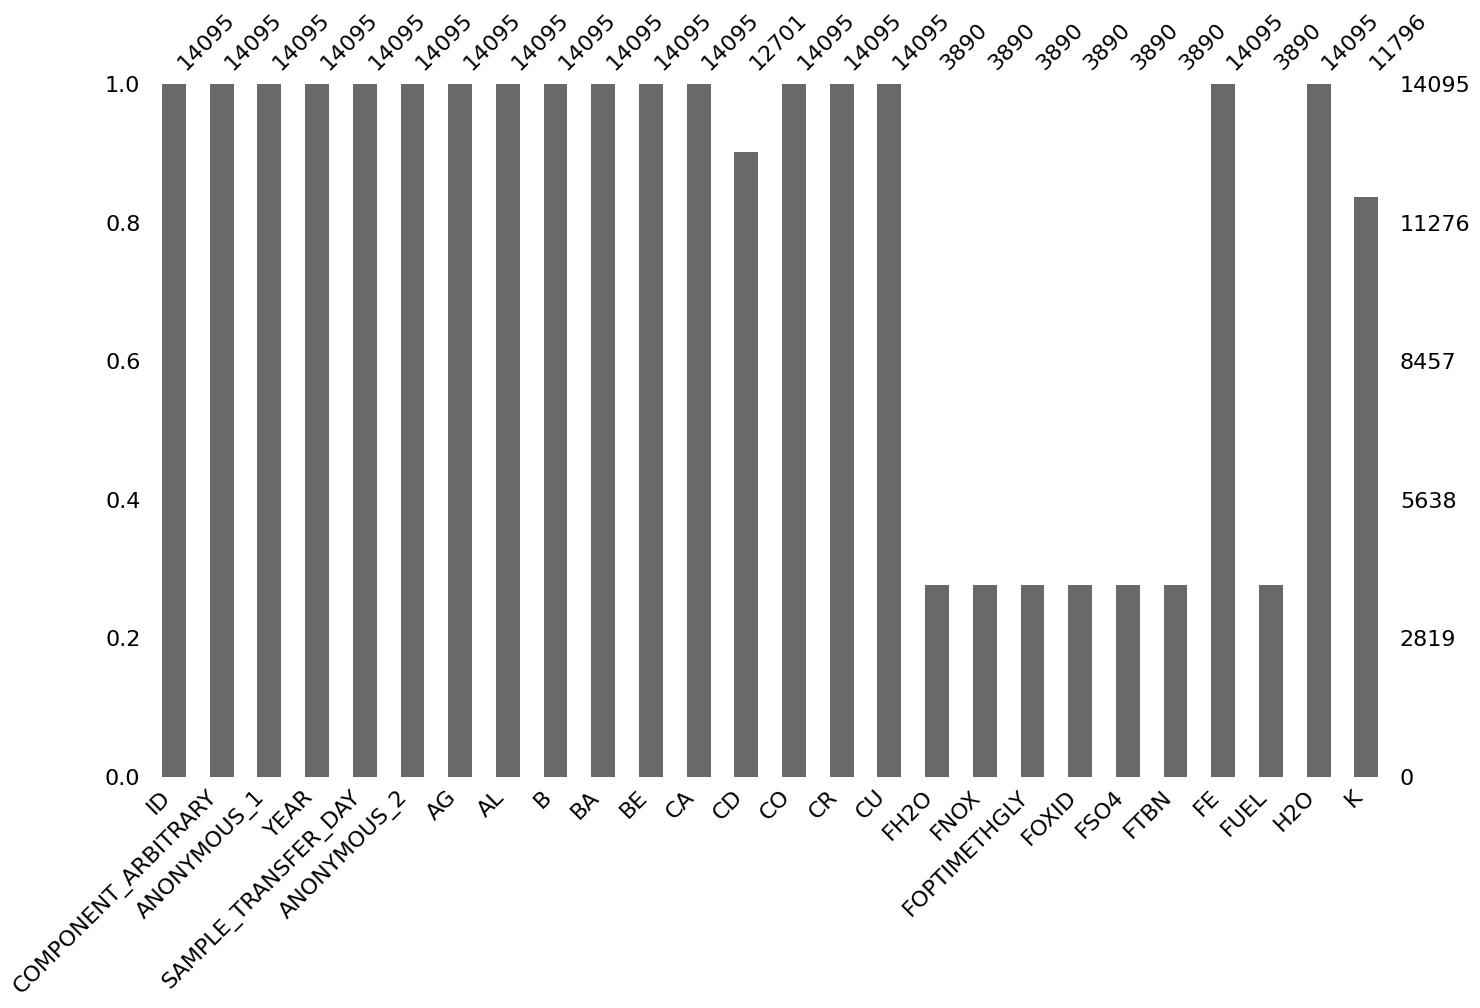

In [24]:
import missingno as msno
msno.bar(oil_train.iloc[:, :26], figsize=(16,9))

### (26~)

<Axes: >

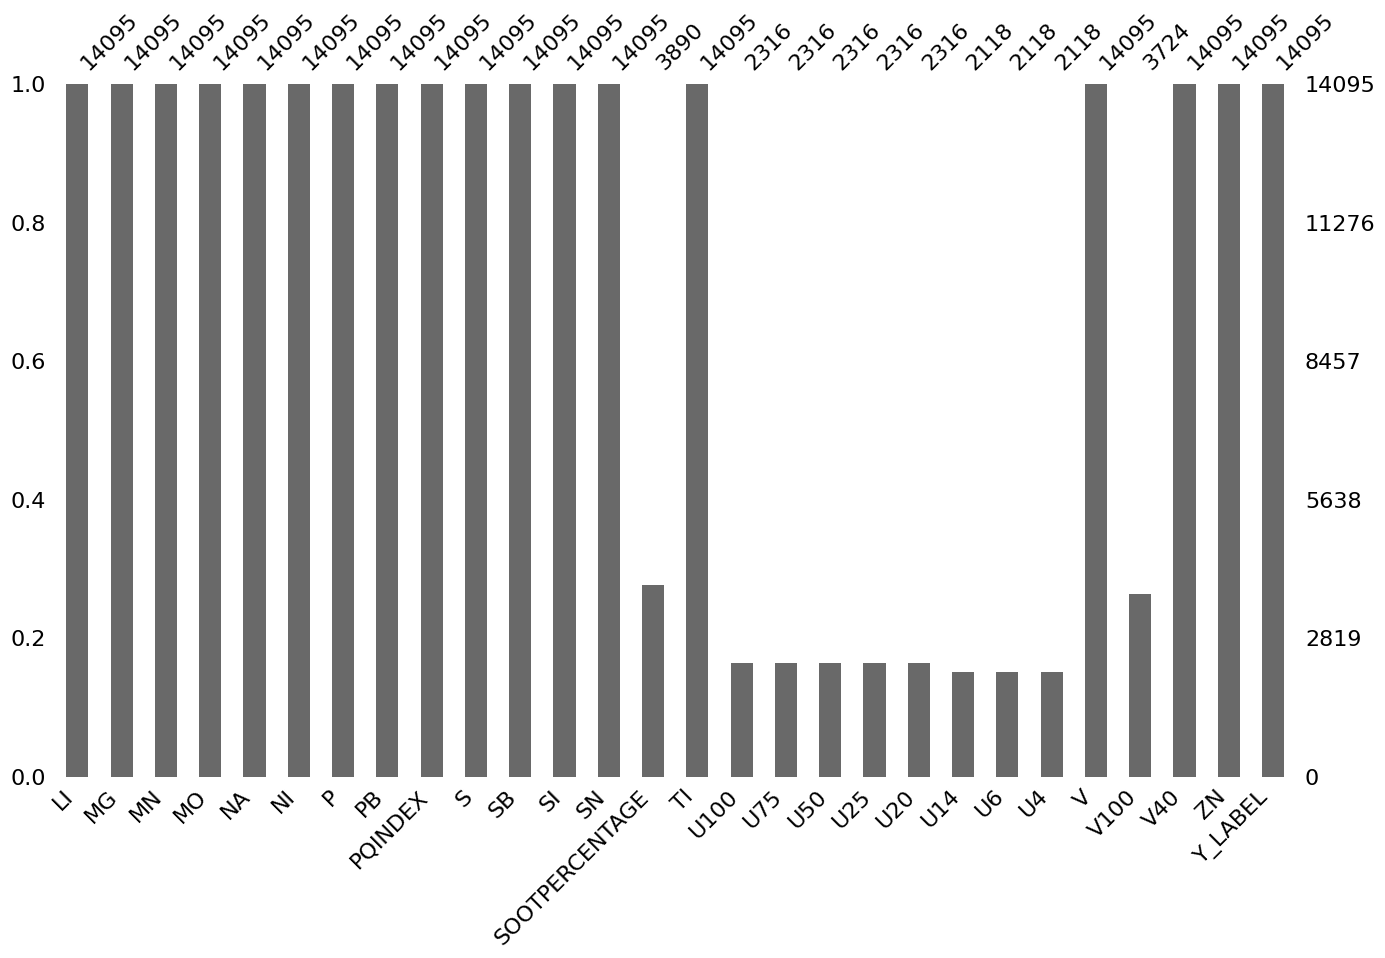

In [25]:
msno.bar(oil_train.iloc[:, 26:], figsize=(16,9))

In [26]:
# # 설명변수만 분리
# x = [oil_train.columns.difference(['Y_LABEL'])]

# # 설명변수명 리스트
# feature_name = x.columns
# plt.figure(figsize=(70, 60))

# for col_idx in range(len(feature_name)):
#     plt.subplot(30, 2, col_idx+1)

#     plt.hist(oil_train[oil_train["Y_LABEL"] == 0][feature_name[col_idx]], label = "normal", alpha = 0.5)
#     plt.hist(oil_train[oil_train["Y_LABEL"] == 1][feature_name[col_idx]], label = "insane", alpha = 0.5)
#     plt.legend()

#     # 그래프 타이틀: feature name
#     plt.title("Feature: "+ feature_name[col_idx], fontsize = 20)

# plt.show()

# 3. 데이터 특성 확인
##  Test 데이터

In [27]:
oil_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6041 non-null   object 
 1   COMPONENT_ARBITRARY  6041 non-null   object 
 2   ANONYMOUS_1          6041 non-null   float64
 3   YEAR                 6041 non-null   int64  
 4   ANONYMOUS_2          6041 non-null   float64
 5   AG                   6041 non-null   int64  
 6   CO                   6041 non-null   int64  
 7   CR                   6041 non-null   int64  
 8   CU                   6041 non-null   int64  
 9   FE                   6041 non-null   int64  
 10  H2O                  6041 non-null   float64
 11  MN                   6041 non-null   int64  
 12  MO                   6041 non-null   int64  
 13  NI                   6041 non-null   int64  
 14  PQINDEX              6041 non-null   int64  
 15  TI                   6041 non-null   i

In [28]:
oil_test.describe()

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
count,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000
mean,-0.985012,2013.656514,-0.959223,0.026817,0.030790,3.155438,37.397285,198.615295,0.024599,3.127462,25.042212,0.883463,475.091210,0.797219,0.044529,110.495135,581.186393
std,0.032952,3.976759,0.119303,0.179981,0.268141,21.120731,153.922102,690.985612,0.335461,11.315785,62.245538,5.708857,1812.652841,7.366433,0.359595,45.381679,530.799040
min,-1.000000,2007.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.900000,1.000000
25%,-0.995454,2010.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,73.000000,38.000000
50%,-0.991338,2014.000000,-1.000000,0.000000,0.000000,1.000000,4.000000,41.000000,0.000000,1.000000,1.000000,0.000000,30.000000,0.000000,0.000000,112.100000,489.000000
75%,-0.980630,2017.000000,-0.954074,0.000000,0.000000,2.000000,17.000000,143.000000,0.000000,2.000000,8.000000,0.000000,173.000000,0.000000,0.000000,138.200000,1115.000000
max,0.625961,2022.000000,1.000000,2.000000,13.000000,1415.000000,4113.000000,30407.000000,15.200000,472.000000,765.000000,155.000000,48976.000000,280.000000,13.000000,388.400000,1932.000000


In [29]:
oil_test.groupby(['COMPONENT_ARBITRARY']).mean()

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
COMPONENT_ARBITRARY,,,,,,,,,,,,,,,,,
COMPONENT1,-0.986427,2013.782843,-0.959741,0.025795,0.012597,2.046791,10.575285,29.414517,0.003599,0.657469,72.391722,0.166767,26.732454,0.094181,0.028194,102.691950,1160.566887
COMPONENT2,-0.981939,2013.864048,-0.957865,0.022155,0.016113,0.515609,53.348439,18.659617,0.006445,0.160121,0.590131,0.027190,29.644512,0.035247,0.009063,53.815086,498.013092
COMPONENT3,-0.985467,2013.406157,-0.961071,0.030122,0.047997,4.998676,38.900695,372.383317,0.045084,5.720622,4.248593,1.661039,923.324727,1.529295,0.068520,138.342784,228.999007
COMPONENT4,-0.983121,2014.600000,-0.945069,0.016667,0.011111,0.102778,104.983333,20.283333,0.000000,0.988889,47.727778,0.038889,18.505556,0.011111,0.016667,69.282500,1083.191667


In [30]:
# show dataframe for each features that we have
dataFeatures = []
dataType     = []
null         = []
nullPCT      = []
unique       = []
minValue     = []
maxValue     = []
#uniqueSample = []


for item in list(oil_test):
    dataFeatures.append(item)

#데이터 타입
for item in dataFeatures:
    dataType.append(oil_test[item].dtype.name)

#결측치 개수
for item in dataFeatures:
    null.append(len(oil_test[oil_train[item].isnull() == True]))

#결측치 비율
for item in dataFeatures:
    nullPCT.append(round(len(oil_test[oil_train[item].isnull() == True])/len(oil_test[item])*100,2))


#가장 작은 값
for item in dataFeatures:
    minValue.append(oil_test[item].min())


#가장 큰 값
for item in dataFeatures:
    maxValue.append(oil_test[item].max())


#고유값 개수
for item in dataFeatures:
    unique.append(oil_test[item].nunique())


#고유값 샘플
#for item in dataFeatures:
#    uniqueSample.append(oil_train[item].unique()[0:2])


#데이터프레임 재생성
oil_test_info = pd.DataFrame({
    'dataFeatures' : dataFeatures,
    'dataType' : dataType,
    'null' : null,
    'nullPCT':nullPCT,
    'unique' : unique,
    'minValue' : minValue,
    'maxValue' : maxValue,
#    'uniqueSample':uniqueSample
})
oil_test_info

<ipython-input-30-48d4975edeb5>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  null.append(len(oil_test[oil_train[item].isnull() == True]))
<ipython-input-30-48d4975edeb5>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nullPCT.append(round(len(oil_test[oil_train[item].isnull() == True])/len(oil_test[item])*100,2))


,dataFeatures,dataType,null,nullPCT,unique,minValue,maxValue
0,ID,object,0,0.0,6041,TEST_0000,TEST_6040
1,COMPONENT_ARBITRARY,object,0,0.0,4,COMPONENT1,COMPONENT4
2,ANONYMOUS_1,float64,0,0.0,2264,-1.0,0.625961
3,YEAR,int64,0,0.0,16,2007,2022
4,ANONYMOUS_2,float64,0,0.0,629,-1.0,1.0
5,AG,int64,0,0.0,3,0,2
6,CO,int64,0,0.0,6,0,13
7,CR,int64,0,0.0,80,0,1415
8,CU,int64,0,0.0,374,0,4113
9,FE,int64,0,0.0,891,0,30407


# 결측치 확인
### (0~10)

<Axes: >

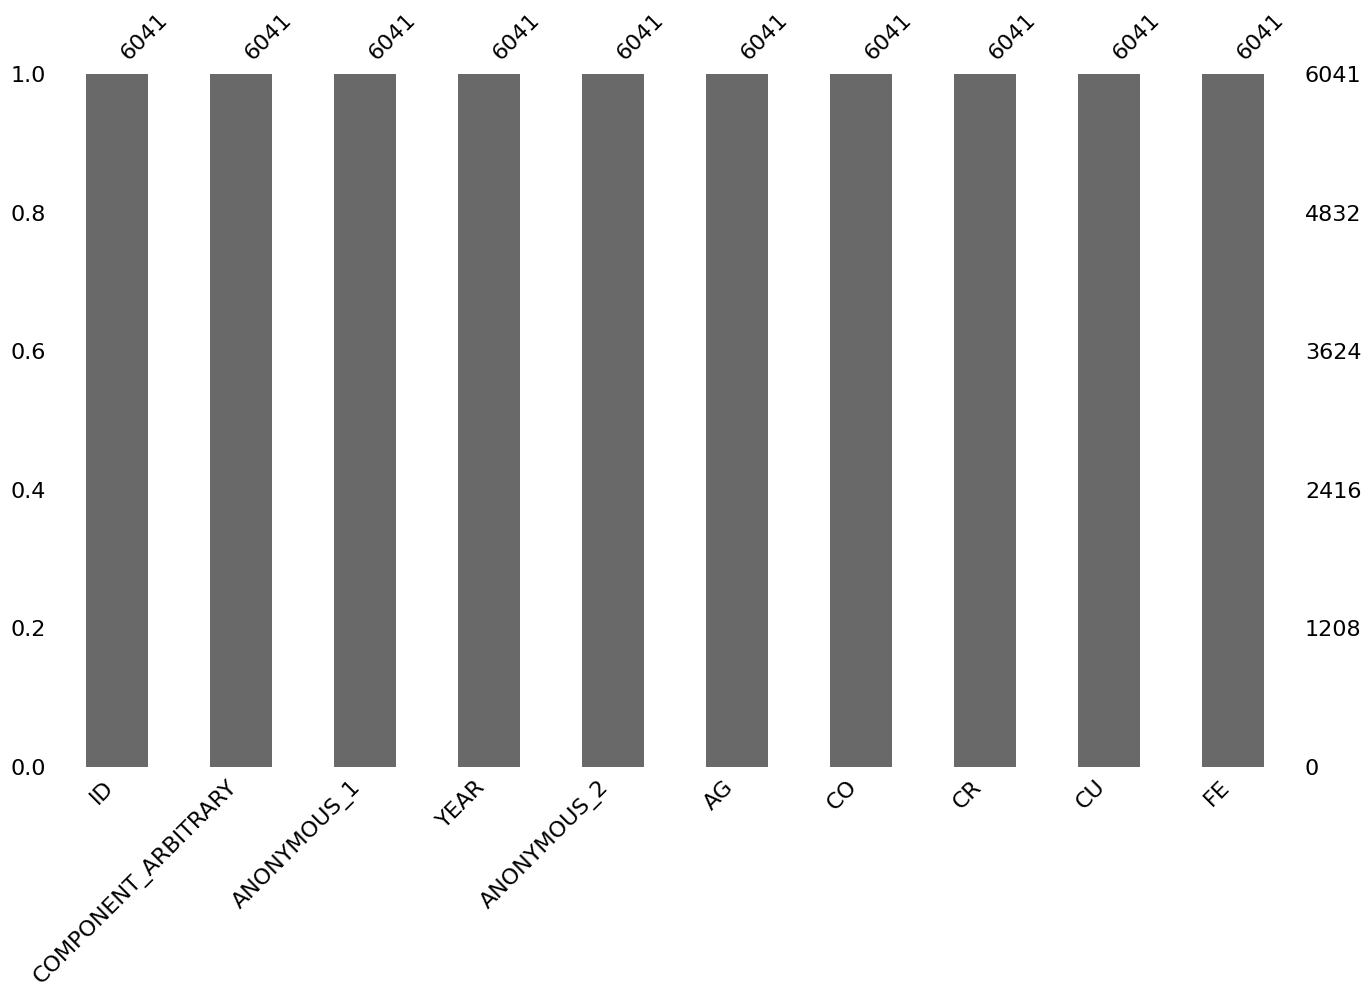

In [31]:
import missingno as msno
msno.bar(oil_test.iloc[:, :10], figsize=(16,9))

### (26~)

<Axes: >

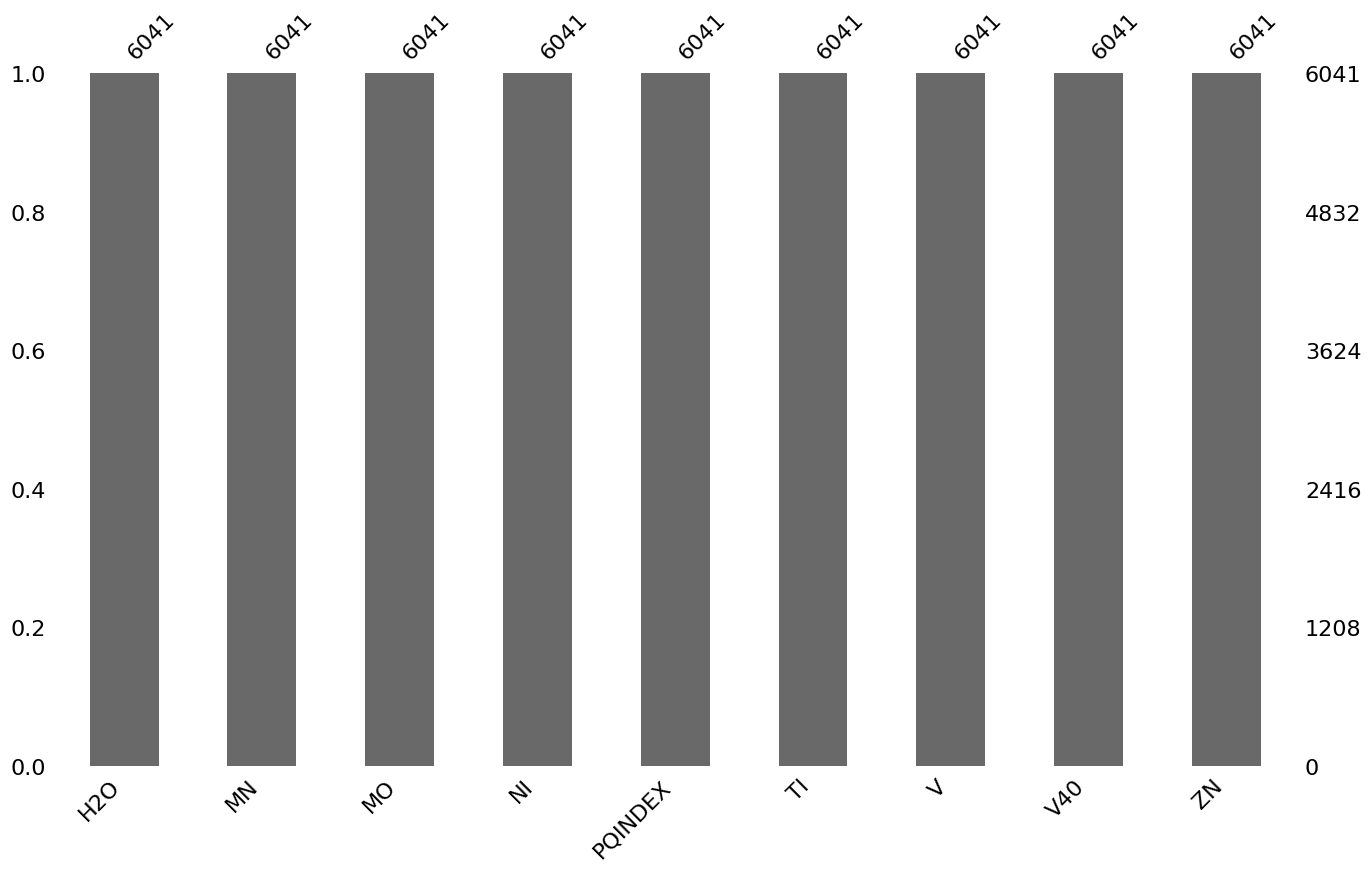

In [32]:
msno.bar(oil_test.iloc[:, 10:], figsize=(16,9))

# 훈련 데이터 전처리
- train 데이터의 Feature 중 Test 데이터에 존재하지 않는 Feature는 대부분 결측치
### 결측치가 존재하는 컬럼 모두 제거

In [33]:
oil_train_missingN = list(oil_train_info[oil_train_info['null'] >= 1]['dataFeatures'])
oil_train_filtered = oil_train.drop(oil_train_missingN,axis=1)

In [34]:
oil_train_missingN

['CD',
 'FH2O',
 'FNOX',
 'FOPTIMETHGLY',
 'FOXID',
 'FSO4',
 'FTBN',
 'FUEL',
 'K',
 'SOOTPERCENTAGE',
 'U100',
 'U75',
 'U50',
 'U25',
 'U20',
 'U14',
 'U6',
 'U4',
 'V100']

결측치가 존재하여 삭제한 컬럼들 : 'CD','FH2O','FNOX','FOPTIMETHGLY','FOXID','FSO4','FTBN','FUEL','K','SOOTPERCENTAGE','U100','U75','U50','U25','U20','U14','U6','U4',
 'V100

In [35]:
oil_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  float64
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  float64
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CO                   14095 non-null  int64  
 13  CR                   14095 non-null  int64  
 14  CU                   14095 non-null  int64  
 15  FE                   14095 non-null 

## 3.2 Visualization Analysis

In [36]:
oil_features = oil_train.columns

In [37]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.2)

In [38]:
plt.rcParams["figure.figsize"] = (16,9)

### 3.2.1 Y_LABEL

<Axes: xlabel='Y_LABEL', ylabel='count'>

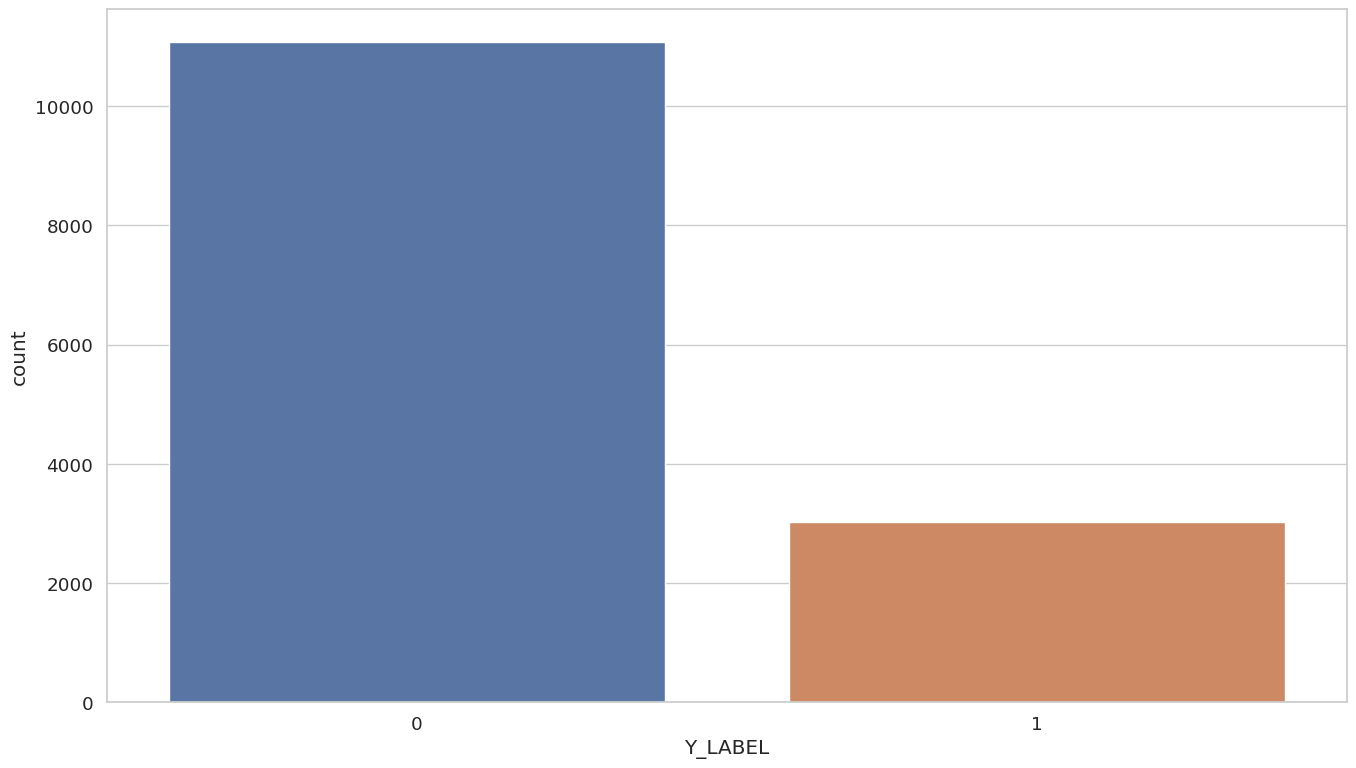

In [39]:
sns.countplot(data=oil_train, x='Y_LABEL')

0 : 정상 / 1 : 이상

In [40]:
oil_train.Y_LABEL.value_counts()

0    11071
1     3024
Name: Y_LABEL, dtype: int64

In [41]:
# ratio of target 0
(oil_train.Y_LABEL.value_counts()[0] / oil_train.shape[0]).round(3)

0.785

In [42]:
# ratio of target 1
(oil_train.Y_LABEL.value_counts()[1] / oil_train.shape[0]).round(3)

0.215

데이터가 균등하진 않음

### 3.2.2 COMPONENT_ARBITRARY

In [44]:
oil_train['COMPONENT_ARBITRARY'].value_counts()

COMPONENT3    7050
COMPONENT1    3890
COMPONENT2    2316
COMPONENT4     839
Name: COMPONENT_ARBITRARY, dtype: int64

<Axes: xlabel='COMPONENT_ARBITRARY', ylabel='count'>

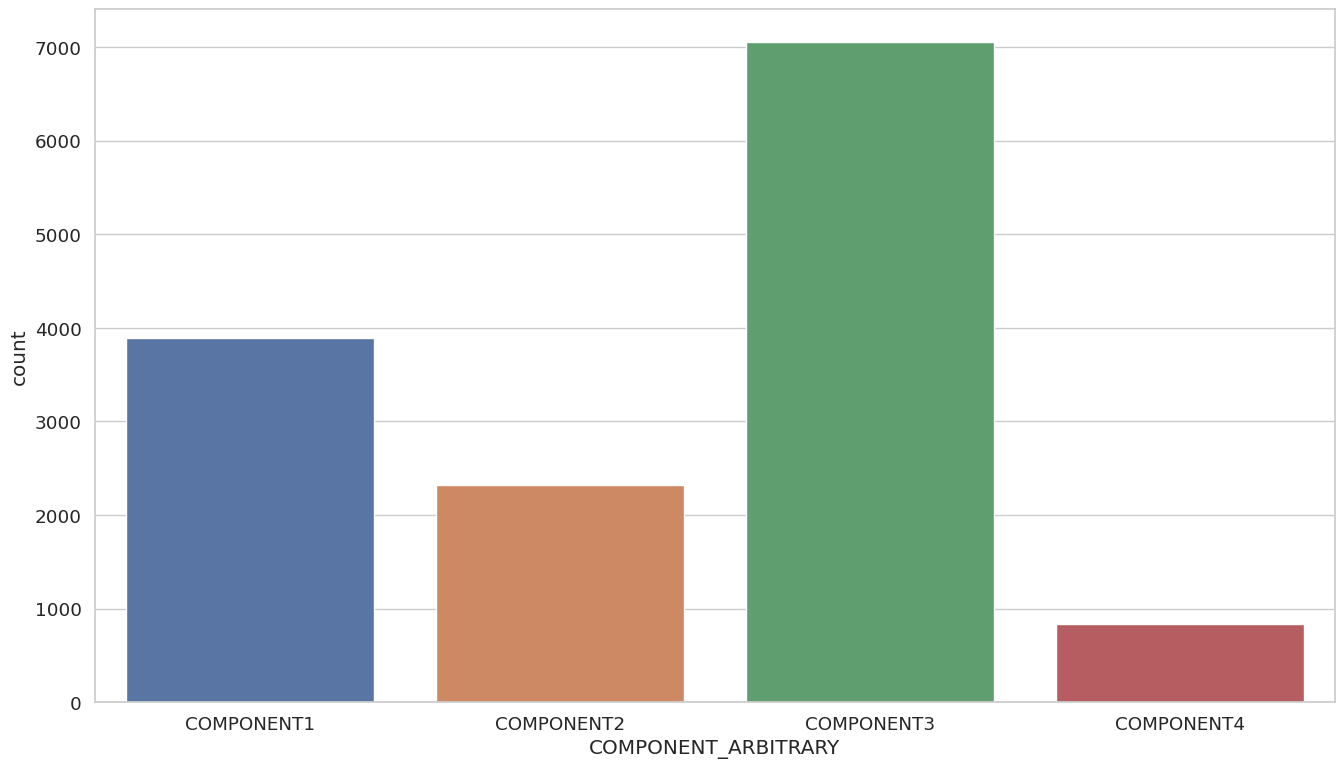

In [45]:
sns.countplot(data = oil_train, x='COMPONENT_ARBITRARY',
              order = ['COMPONENT1', 'COMPONENT2', 'COMPONENT3', 'COMPONENT4'])

<Axes: xlabel='COMPONENT_ARBITRARY', ylabel='count'>

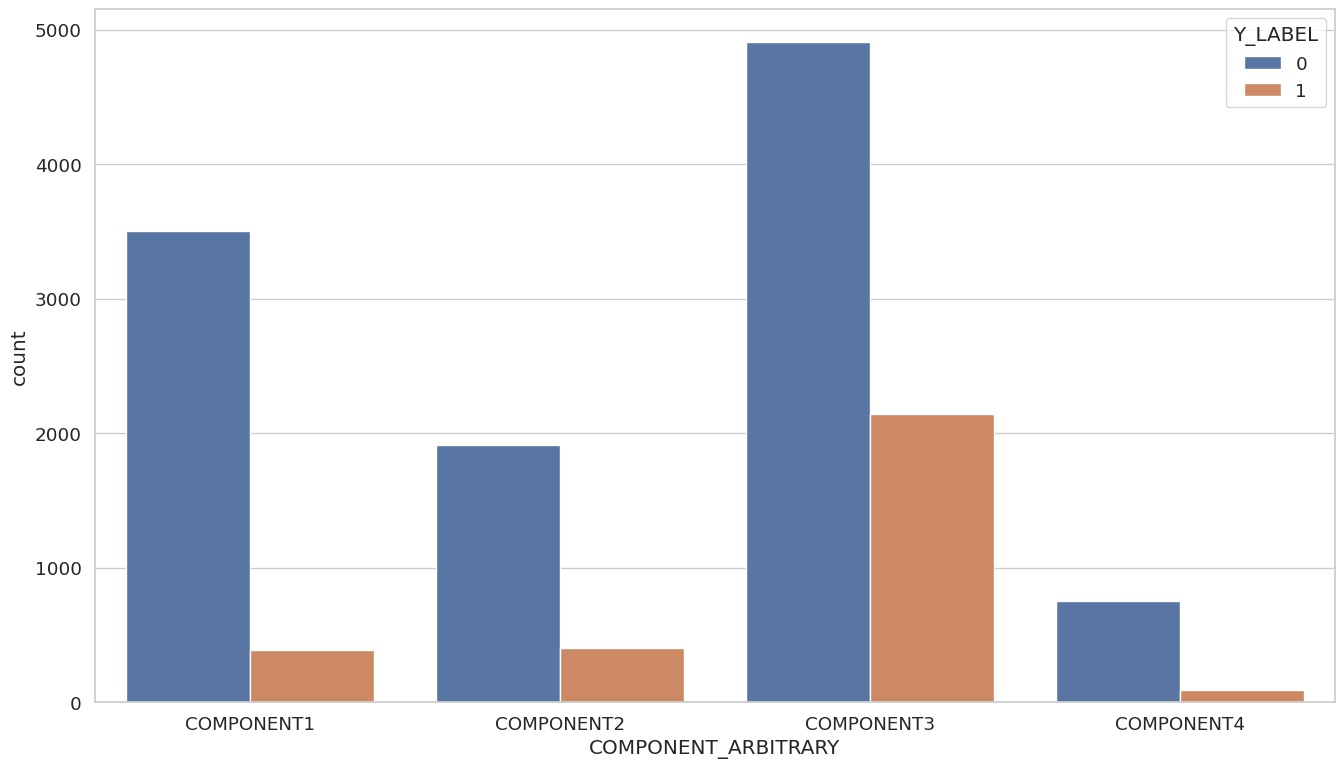

In [46]:
#hue: 카테고리 추가
sns.countplot(data = oil_train, x='COMPONENT_ARBITRARY', hue='Y_LABEL',
              order = ['COMPONENT1', 'COMPONENT2', 'COMPONENT3', 'COMPONENT4'])

# 4.Data Preprocessing

## 4.1 Train Test Data Concatenating

In [47]:
oil_train_features = oil_train.columns
oil_train_features

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
       'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL'],
      dtype='object')

In [48]:
oil_test_features = oil_test.columns
oil_test_features

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN'],
      dtype='object')

In [49]:
oil_data = pd.concat([oil_train, oil_test], ignore_index=True)

In [50]:
#train 14000행과 test셋 6000행 합치기
oil_data.head(3)
print(oil_data.shape)

(20136, 54)


## 5.2 Drop Columns

In [52]:
# ID와 Y_Label 버리기
oil_data = oil_data.drop(['ID','Y_LABEL'], axis=1)
oil_data.head()

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,U50,U25,U20,U14,U6,U4,V,V100,V40,ZN
0,COMPONENT3,-0.996688,2011,7.0,-1.000000,0,3.0,93.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75
1,COMPONENT2,-0.997615,2021,51.0,-0.962963,0,2.0,19.0,0.0,0.0,...,1.0,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652
2,COMPONENT2,-0.990356,2015,2.0,-1.000000,0,110.0,1.0,1.0,0.0,...,0.0,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412
3,COMPONENT3,-0.956456,2010,2.0,-1.000000,0,8.0,3.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7
4,COMPONENT3,-0.979867,2015,4.0,-1.000000,0,1.0,157.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128


## 5.3 One-Hot Encoding
### COMPONENT_ARBITRARY 형 변환

In [54]:
oil_data_ohe = pd.get_dummies(oil_data, columns = ['COMPONENT_ARBITRARY'])
oil_data_ohe.head()

,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,U6,U4,V,V100,V40,ZN,COMPONENT_ARBITRARY_COMPONENT1,COMPONENT_ARBITRARY_COMPONENT2,COMPONENT_ARBITRARY_COMPONENT3,COMPONENT_ARBITRARY_COMPONENT4
0,-0.996688,2011,7.0,-1.000000,0,3.0,93.0,0.0,0.0,3059.0,...,NaN,NaN,0,NaN,154.0,75,0,0,1,0
1,-0.997615,2021,51.0,-0.962963,0,2.0,19.0,0.0,0.0,2978.0,...,216.0,1454.0,0,NaN,44.0,652,0,1,0,0
2,-0.990356,2015,2.0,-1.000000,0,110.0,1.0,1.0,0.0,17.0,...,11261.0,41081.0,0,NaN,72.6,412,0,1,0,0
3,-0.956456,2010,2.0,-1.000000,0,8.0,3.0,0.0,0.0,1960.0,...,NaN,NaN,0,NaN,133.3,7,0,0,1,0
4,-0.979867,2015,4.0,-1.000000,0,1.0,157.0,0.0,0.0,71.0,...,NaN,NaN,0,NaN,133.1,128,0,0,1,0


## 5.6 Missing Value Manipulate

In [56]:
oil_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20136 entries, 0 to 20135
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ANONYMOUS_1                     20136 non-null  float64
 1   YEAR                            20136 non-null  int64  
 2   SAMPLE_TRANSFER_DAY             14095 non-null  float64
 3   ANONYMOUS_2                     20136 non-null  float64
 4   AG                              20136 non-null  int64  
 5   AL                              14095 non-null  float64
 6   B                               14095 non-null  float64
 7   BA                              14095 non-null  float64
 8   BE                              14095 non-null  float64
 9   CA                              14095 non-null  float64
 10  CD                              12701 non-null  float64
 11  CO                              20136 non-null  int64  
 12  CR                              

In [57]:
oil_data_ohe = oil_data_ohe.astype({'COMPONENT_ARBITRARY_COMPONENT1':'float64'})
oil_data_ohe = oil_data_ohe.astype({'COMPONENT_ARBITRARY_COMPONENT2':'float64'})
oil_data_ohe = oil_data_ohe.astype({'COMPONENT_ARBITRARY_COMPONENT3':'float64'})
oil_data_ohe = oil_data_ohe.astype({'COMPONENT_ARBITRARY_COMPONENT4':'float64'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20136 entries, 0 to 20135
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ANONYMOUS_1                     20136 non-null  float64
 1   YEAR                            20136 non-null  int64  
 2   SAMPLE_TRANSFER_DAY             14095 non-null  float64
 3   ANONYMOUS_2                     20136 non-null  float64
 4   AG                              20136 non-null  int64  
 5   AL                              14095 non-null  float64
 6   B                               14095 non-null  float64
 7   BA                              14095 non-null  float64
 8   BE                              14095 non-null  float64
 9   CA                              14095 non-null  float64
 10  CD                              12701 non-null  float64
 11  CO                              20136 non-null  int64  
 12  CR                              

In [64]:
# show dataframe for each features that we have
dataFeatures = []
dataType     = []
null         = []
nullPCT      = []
unique       = []
minValue     = []
maxValue     = []
#uniqueSample = []

for item in list(oil_data_ohe):
    dataFeatures.append(item)

#데이터 타입
for item in dataFeatures:
    dataType.append(oil_data_ohe[item].dtype.name)

#결측치 개수
for item in dataFeatures:
    null.append(len(oil_data_ohe[oil_data_ohe[item].isnull() == True]))

#결측치 비율
for item in dataFeatures:
    nullPCT.append(round(len(oil_data_ohe[oil_data_ohe[item].isnull() == True])/len(oil_data_ohe[item])*100,2))


#가장 작은 값
for item in dataFeatures:
    minValue.append(oil_data_ohe[item].min())


#가장 큰 값
for item in dataFeatures:
    maxValue.append(oil_data_ohe[item].max())


#고유값 개수
for item in dataFeatures:
    unique.append(oil_data_ohe[item].nunique())


#고유값 샘플
#for item in dataFeatures:
#    uniqueSample.append(oil_train[item].unique()[0:2])


#데이터프레임 재생성
oil_data_ohe_info = pd.DataFrame({
    'dataFeatures' : dataFeatures,
    'dataType' : dataType,
    'null' : null,
    'nullPCT':nullPCT,
    'unique' : unique,
    'minValue' : minValue,
    'maxValue' : maxValue,
#    'uniqueSample':uniqueSample
})
oil_data_ohe_info

,dataFeatures,dataType,null,nullPCT,unique,minValue,maxValue
0,ANONYMOUS_1,float64,0,0.00,3201,-1.0,1.0
1,YEAR,int64,0,0.00,16,2007.0,2022.0
2,SAMPLE_TRANSFER_DAY,float64,6041,30.00,107,0.0,368.0
3,ANONYMOUS_2,float64,0,0.00,979,-1.0,1.0
4,AG,int64,0,0.00,4,0.0,3.0
5,AL,float64,6041,30.00,328,0.0,4630.0
6,B,float64,6041,30.00,504,0.0,2051.0
7,BA,float64,6041,30.00,38,0.0,216.0
8,BE,float64,6041,30.00,9,0.0,9.0
9,CA,float64,6041,30.00,2581,0.0,6609.0


In [96]:
oil_ohe_missingN = list(oil_data_ohe_info[oil_data_ohe_info['nullPCT'] >= 1]['dataFeatures'])
print(oil_ohe_missingN)

['SAMPLE_TRANSFER_DAY', 'AL', 'B', 'BA', 'BE', 'CA', 'CD', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'K', 'LI', 'MG', 'NA', 'P', 'PB', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100']


In [97]:
oil_ohe_filtered = oil_data_ohe.drop(oil_ohe_missingN, axis=1)
oil_ohe_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20136 entries, 0 to 20135
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ANONYMOUS_1                     20136 non-null  float64
 1   YEAR                            20136 non-null  int64  
 2   ANONYMOUS_2                     20136 non-null  float64
 3   AG                              20136 non-null  int64  
 4   CO                              20136 non-null  int64  
 5   CR                              20136 non-null  int64  
 6   CU                              20136 non-null  int64  
 7   FE                              20136 non-null  int64  
 8   H2O                             20136 non-null  float64
 9   MN                              20136 non-null  int64  
 10  MO                              20136 non-null  int64  
 11  NI                              20136 non-null  int64  
 12  PQINDEX                         

## 5.4 Min-Max Scaler

In [98]:
from sklearn.preprocessing import MinMaxScaler

In [99]:
scaler = MinMaxScaler()

In [100]:
scaled = scaler.fit_transform(oil_ohe_filtered)

In [101]:
all_data = pd.DataFrame(scaled, columns = oil_ohe_filtered.columns)

In [102]:
all_data

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,...,NI,PQINDEX,TI,V,V40,ZN,COMPONENT_ARBITRARY_COMPONENT1,COMPONENT_ARBITRARY_COMPONENT2,COMPONENT_ARBITRARY_COMPONENT3,COMPONENT_ARBITRARY_COMPONENT4
0,0.001656,0.266667,0.000000,0.0,0.0,0.005421,0.013682,0.028007,0.0,0.018244,...,0.034091,0.149821,0.012407,0.0,0.053249,0.035178,0.0,0.0,1.0,0.0
1,0.001193,0.933333,0.018519,0.0,0.0,0.000000,0.005438,0.000063,0.0,0.000000,...,0.000000,0.000335,0.000000,0.0,0.014484,0.305816,0.0,1.0,0.0,0.0
2,0.004822,0.533333,0.000000,0.0,0.0,0.000417,0.000351,0.000126,0.0,0.000000,...,0.000000,0.000300,0.000000,0.0,0.024563,0.193246,0.0,1.0,0.0,0.0
3,0.021772,0.200000,0.000000,0.0,0.0,0.000000,0.000175,0.001167,0.0,0.001140,...,0.000000,0.000775,0.000000,0.0,0.045954,0.003283,0.0,0.0,1.0,0.0
4,0.010066,0.533333,0.000000,0.0,0.0,0.000000,0.000000,0.002239,0.0,0.000000,...,0.000000,0.003823,0.000000,0.0,0.045884,0.060038,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20131,0.008366,0.666667,0.000000,0.0,0.0,0.000000,0.000175,0.000315,0.0,0.000000,...,0.000000,0.000176,0.000000,0.0,0.034395,0.553471,1.0,0.0,0.0,0.0
20132,0.007466,0.333333,0.000000,0.0,0.0,0.000000,0.001052,0.000347,0.0,0.000000,...,0.000000,0.000247,0.000000,0.0,0.021004,0.027205,0.0,1.0,0.0,0.0
20133,0.001418,0.533333,0.044021,0.0,0.0,0.000000,0.000351,0.002208,0.0,0.000000,...,0.000000,0.001409,0.000000,0.0,0.050677,0.004690,0.0,0.0,1.0,0.0
20134,0.002368,0.466667,0.000000,0.0,0.0,0.000000,0.000000,0.000158,0.0,0.000000,...,0.000000,0.000317,0.000000,0.0,0.033867,0.426360,1.0,0.0,0.0,0.0


## 5.7 Train Test Data Splitting

In [103]:
num = len(oil_train)
print(num)
labeled = oil_train.Y_LABEL
print(labeled)


14095
0        1
1        0
2        0
3        0
4        0
        ..
14090    0
14091    0
14092    0
14093    0
14094    1
Name: Y_LABEL, Length: 14095, dtype: int64


In [104]:
df = all_data[:num]
df_test = all_data[num:]
print(df.shape, df_test.shape)

(14095, 21) (6041, 21)


In [105]:
df['Y_LABEL'] = labeled
labeled

<ipython-input-105-0fb6fd500523>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Y_LABEL'] = labeled


0        1
1        0
2        0
3        0
4        0
        ..
14090    0
14091    0
14092    0
14093    0
14094    1
Name: Y_LABEL, Length: 14095, dtype: int64

In [106]:
df.head(3)

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,...,PQINDEX,TI,V,V40,ZN,COMPONENT_ARBITRARY_COMPONENT1,COMPONENT_ARBITRARY_COMPONENT2,COMPONENT_ARBITRARY_COMPONENT3,COMPONENT_ARBITRARY_COMPONENT4,Y_LABEL
0,0.001656,0.266667,0.000000,0.0,0.0,0.005421,0.013682,0.028007,0.0,0.018244,...,0.149821,0.012407,0.0,0.053249,0.035178,0.0,0.0,1.0,0.0,1
1,0.001193,0.933333,0.018519,0.0,0.0,0.000000,0.005438,0.000063,0.0,0.000000,...,0.000335,0.000000,0.0,0.014484,0.305816,0.0,1.0,0.0,0.0,0
2,0.004822,0.533333,0.000000,0.0,0.0,0.000417,0.000351,0.000126,0.0,0.000000,...,0.000300,0.000000,0.0,0.024563,0.193246,0.0,1.0,0.0,0.0,0


In [107]:
df_test.head(3)

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,...,NI,PQINDEX,TI,V,V40,ZN,COMPONENT_ARBITRARY_COMPONENT1,COMPONENT_ARBITRARY_COMPONENT2,COMPONENT_ARBITRARY_COMPONENT3,COMPONENT_ARBITRARY_COMPONENT4
14095,0.002494,0.466667,0.00000,0.0,0.0,0.001251,0.007543,0.001419,0.0,0.002281,...,0.000000,0.000264,0.0,0.0,0.029109,0.472326,1.0,0.0,0.0,0.0
14096,0.007974,0.533333,0.00000,0.0,0.0,0.000000,0.000000,0.005204,0.0,0.001140,...,0.005682,0.001092,0.0,0.0,0.053778,0.016417,0.0,0.0,1.0,0.0
14097,0.011191,0.933333,0.04836,0.0,0.0,0.000417,0.002105,0.003186,0.0,0.018244,...,0.000000,0.002784,0.0,0.0,0.015471,0.694184,0.0,0.0,1.0,0.0


In [108]:
list(df_test.columns)

['ANONYMOUS_1',
 'YEAR',
 'ANONYMOUS_2',
 'AG',
 'CO',
 'CR',
 'CU',
 'FE',
 'H2O',
 'MN',
 'MO',
 'NI',
 'PQINDEX',
 'TI',
 'V',
 'V40',
 'ZN',
 'COMPONENT_ARBITRARY_COMPONENT1',
 'COMPONENT_ARBITRARY_COMPONENT2',
 'COMPONENT_ARBITRARY_COMPONENT3',
 'COMPONENT_ARBITRARY_COMPONENT4']

In [109]:
df_test = df_test[['ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN', 'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2',
 'COMPONENT_ARBITRARY_COMPONENT3',
 'COMPONENT_ARBITRARY_COMPONENT4']]

In [110]:
df_test

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,...,NI,PQINDEX,TI,V,V40,ZN,COMPONENT_ARBITRARY_COMPONENT1,COMPONENT_ARBITRARY_COMPONENT2,COMPONENT_ARBITRARY_COMPONENT3,COMPONENT_ARBITRARY_COMPONENT4
14095,0.002494,0.466667,0.000000,0.0,0.0,0.001251,0.007543,0.001419,0.0,0.002281,...,0.000000,0.000264,0.0,0.0,0.029109,0.472326,1.0,0.0,0.0,0.0
14096,0.007974,0.533333,0.000000,0.0,0.0,0.000000,0.000000,0.005204,0.0,0.001140,...,0.005682,0.001092,0.0,0.0,0.053778,0.016417,0.0,0.0,1.0,0.0
14097,0.011191,0.933333,0.048360,0.0,0.0,0.000417,0.002105,0.003186,0.0,0.018244,...,0.000000,0.002784,0.0,0.0,0.015471,0.694184,0.0,0.0,1.0,0.0
14098,0.005797,0.200000,0.000000,0.0,0.0,0.002502,0.001228,0.002082,0.0,0.001140,...,0.017045,0.000247,0.0,0.0,0.037708,0.479831,1.0,0.0,0.0,0.0
14099,0.007187,0.666667,0.000000,0.0,0.0,0.000000,0.000877,0.000095,0.0,0.000000,...,0.000000,0.000141,0.0,0.0,0.015471,0.176829,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20131,0.008366,0.666667,0.000000,0.0,0.0,0.000000,0.000175,0.000315,0.0,0.000000,...,0.000000,0.000176,0.0,0.0,0.034395,0.553471,1.0,0.0,0.0,0.0
20132,0.007466,0.333333,0.000000,0.0,0.0,0.000000,0.001052,0.000347,0.0,0.000000,...,0.000000,0.000247,0.0,0.0,0.021004,0.027205,0.0,1.0,0.0,0.0
20133,0.001418,0.533333,0.044021,0.0,0.0,0.000000,0.000351,0.002208,0.0,0.000000,...,0.000000,0.001409,0.0,0.0,0.050677,0.004690,0.0,0.0,1.0,0.0
20134,0.002368,0.466667,0.000000,0.0,0.0,0.000000,0.000000,0.000158,0.0,0.000000,...,0.000000,0.000317,0.0,0.0,0.033867,0.426360,1.0,0.0,0.0,0.0


# 5.Make Model and predict

## 7.1 GBM model

In [111]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [112]:
gbm_model = GradientBoostingClassifier()

In [113]:
# teacher model
gbm_model.fit(df.iloc[:, :-1], df.iloc[:, -1])

GradientBoostingClassifier()

In [114]:
y_pred_prob = gbm_model.predict_proba(df.iloc[:, :-1])

In [115]:
y_pred_prob

array([[0.05262971, 0.94737029],
       [0.87356905, 0.12643095],
       [0.93094897, 0.06905103],
       ...,
       [0.75536386, 0.24463614],
       [0.9432799 , 0.0567201 ],
       [0.21200158, 0.78799842]])

In [116]:
y_pred_prob.shape

(14095, 2)

In [117]:
y_pred_prob[:, 1]

array([0.94737029, 0.12643095, 0.06905103, ..., 0.24463614, 0.0567201 ,
       0.78799842])

In [118]:
gbm_model_regressor = GradientBoostingRegressor()

In [119]:
df_oil_sub = df[df_test.columns]
df_oil_sub.head()

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,...,NI,PQINDEX,TI,V,V40,ZN,COMPONENT_ARBITRARY_COMPONENT1,COMPONENT_ARBITRARY_COMPONENT2,COMPONENT_ARBITRARY_COMPONENT3,COMPONENT_ARBITRARY_COMPONENT4
0,0.001656,0.266667,0.000000,0.0,0.0,0.005421,0.013682,0.028007,0.0,0.018244,...,0.034091,0.149821,0.012407,0.0,0.053249,0.035178,0.0,0.0,1.0,0.0
1,0.001193,0.933333,0.018519,0.0,0.0,0.000000,0.005438,0.000063,0.0,0.000000,...,0.000000,0.000335,0.000000,0.0,0.014484,0.305816,0.0,1.0,0.0,0.0
2,0.004822,0.533333,0.000000,0.0,0.0,0.000417,0.000351,0.000126,0.0,0.000000,...,0.000000,0.000300,0.000000,0.0,0.024563,0.193246,0.0,1.0,0.0,0.0
3,0.021772,0.200000,0.000000,0.0,0.0,0.000000,0.000175,0.001167,0.0,0.001140,...,0.000000,0.000775,0.000000,0.0,0.045954,0.003283,0.0,0.0,1.0,0.0
4,0.010066,0.533333,0.000000,0.0,0.0,0.000000,0.000000,0.002239,0.0,0.000000,...,0.000000,0.003823,0.000000,0.0,0.045884,0.060038,0.0,0.0,1.0,0.0


In [120]:
gbm_model_regressor.fit(df_oil_sub, y_pred_prob[:, 1])

GradientBoostingRegressor()

In [121]:
y_pred = gbm_model_regressor.predict(df_test)

In [124]:
oil_ss.Y_LABEL = pd.Series(np.where(y_pred >=0.5, 1, 0))

In [125]:
oil_ss

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
6036,TEST_6036,0
6037,TEST_6037,0
6038,TEST_6038,0
6039,TEST_6039,0


In [127]:
oil_ss.Y_LABEL.value_counts()

0    4978
1    1063
Name: Y_LABEL, dtype: int64

In [129]:
oil_ss.loc[oil_ss.Y_LABEL == 1]

,ID,Y_LABEL
5,TEST_0005,1
9,TEST_0009,1
10,TEST_0010,1
21,TEST_0021,1
23,TEST_0023,1
...,...,...
6029,TEST_6029,1
6030,TEST_6030,1
6031,TEST_6031,1
6034,TEST_6034,1


In [130]:
file_path = '/content/drive/MyDrive/GBTHackerton/submission/'
oil_ss.to_csv(file_path + 'submissionGB.csv', index=False)

## 7.2 XGBoost model

In [131]:
!pip install xgboost

In [132]:
import xgboost as xgb

In [133]:
xgb_model = xgb.XGBClassifier()

In [134]:
xgb_model.fit(df.iloc[:, :-1], df.iloc[:, -1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [135]:
y_pred_prob = xgb_model.predict_proba(df.iloc[:, :-1])

In [136]:
xgb_model_regressor = xgb.XGBRegressor()

In [137]:
xgb_model_regressor.fit(df_oil_sub, y_pred_prob[:, 1])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [138]:
y_pred = gbm_model_regressor.predict(df_test)

In [139]:
oil_ss.Y_LABEL = pd.Series(np.where(y_pred >=0.5, 1, 0))

In [140]:
oil_ss.Y_LABEL.value_counts()

0    4978
1    1063
Name: Y_LABEL, dtype: int64

In [141]:
oil_ss.loc[oil_ss.Y_LABEL == 1]

,ID,Y_LABEL
5,TEST_0005,1
9,TEST_0009,1
10,TEST_0010,1
21,TEST_0021,1
23,TEST_0023,1
...,...,...
6029,TEST_6029,1
6030,TEST_6030,1
6031,TEST_6031,1
6034,TEST_6034,1


In [142]:
oil_ss.to_csv(file_path + 'submissionXGB.csv', index=False)

## 7.3 LightGBM model

In [143]:
# !pip install lightbgm

In [144]:
import lightgbm as lgbm

In [145]:
lgbm_model = lgbm.LGBMClassifier()

In [146]:
lgbm_model.fit(df.iloc[:, :-1], df.iloc[:, -1])

[LightGBM] [Info] Number of positive: 3024, number of negative: 11071
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 14095, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214544 -> initscore=-1.297749
[LightGBM] [Info] Start training from score -1.297749


LGBMClassifier()

In [147]:
y_pred_prob = lgbm_model.predict_proba(df.iloc[:, :-1])

In [148]:
lgbm_model_regressor = lgbm.LGBMRegressor()

In [149]:
lgbm_model_regressor.fit(df_oil_sub, y_pred_prob[:, 1])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 14095, number of used features: 21
[LightGBM] [Info] Start training from score 0.214649


LGBMRegressor()

In [150]:
y_pred = lgbm_model_regressor.predict(df_test)

In [151]:
oil_ss.Y_LABEL = pd.Series(np.where(y_pred >=0.5, 1, 0))

In [152]:
oil_ss.Y_LABEL.value_counts()

0    4917
1    1124
Name: Y_LABEL, dtype: int64

In [153]:
oil_ss.loc[oil_ss.Y_LABEL == 1]

,ID,Y_LABEL
3,TEST_0003,1
5,TEST_0005,1
6,TEST_0006,1
9,TEST_0009,1
10,TEST_0010,1
...,...,...
6029,TEST_6029,1
6030,TEST_6030,1
6031,TEST_6031,1
6035,TEST_6035,1


In [155]:
#file_path = '/content/drive/MyDrive/[03]Python_Data_Analysis/[13]Dacon/[01]oil/'
oil_ss.to_csv(file_path + 'submissionLGBM.csv', index=False)

## 7.4 CatBoost model

In [156]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [157]:
import catboost as cb

In [158]:
cb_model = cb.CatBoostClassifier()

In [159]:
cb_model.fit(df.iloc[:, :-1], df.iloc[:, -1])

Learning rate set to 0.031885
0:	learn: 0.6694067	total: 75.1ms	remaining: 1m 15s
1:	learn: 0.6468053	total: 94.1ms	remaining: 47s
2:	learn: 0.6255641	total: 114ms	remaining: 37.8s
3:	learn: 0.6062706	total: 132ms	remaining: 32.7s
4:	learn: 0.5890015	total: 162ms	remaining: 32.2s
5:	learn: 0.5730865	total: 189ms	remaining: 31.3s
6:	learn: 0.5573838	total: 222ms	remaining: 31.5s
7:	learn: 0.5426104	total: 241ms	remaining: 29.9s
8:	learn: 0.5281528	total: 272ms	remaining: 30s
9:	learn: 0.5159243	total: 304ms	remaining: 30.1s
10:	learn: 0.5020974	total: 320ms	remaining: 28.8s
11:	learn: 0.4918338	total: 342ms	remaining: 28.2s
12:	learn: 0.4804923	total: 376ms	remaining: 28.5s
13:	learn: 0.4713686	total: 393ms	remaining: 27.7s
14:	learn: 0.4632441	total: 411ms	remaining: 27s
15:	learn: 0.4537310	total: 437ms	remaining: 26.9s
16:	learn: 0.4464523	total: 473ms	remaining: 27.4s
17:	learn: 0.4398089	total: 508ms	remaining: 27.7s
18:	learn: 0.4328120	total: 535ms	remaining: 27.6s
19:	learn: 0.4

In [160]:
y_pred_prob = cb_model.predict_proba(df.iloc[:, :-1])

In [161]:
cb_model_regressor = cb.CatBoostRegressor()

In [162]:
cb_model_regressor.fit(df_oil_sub, y_pred_prob[:, 1])

Learning rate set to 0.062192
0:	learn: 0.2825343	total: 14.3ms	remaining: 14.3s
1:	learn: 0.2708292	total: 30.7ms	remaining: 15.3s
2:	learn: 0.2606945	total: 46.6ms	remaining: 15.5s
3:	learn: 0.2511588	total: 89.5ms	remaining: 22.3s
4:	learn: 0.2429257	total: 128ms	remaining: 25.5s
5:	learn: 0.2342292	total: 150ms	remaining: 24.9s
6:	learn: 0.2261095	total: 174ms	remaining: 24.6s
7:	learn: 0.2189802	total: 214ms	remaining: 26.6s
8:	learn: 0.2123994	total: 236ms	remaining: 26s
9:	learn: 0.2050272	total: 264ms	remaining: 26.1s
10:	learn: 0.1982382	total: 282ms	remaining: 25.4s
11:	learn: 0.1927016	total: 309ms	remaining: 25.4s
12:	learn: 0.1868217	total: 330ms	remaining: 25.1s
13:	learn: 0.1822570	total: 357ms	remaining: 25.1s
14:	learn: 0.1781869	total: 401ms	remaining: 26.4s
15:	learn: 0.1743947	total: 414ms	remaining: 25.5s
16:	learn: 0.1709258	total: 428ms	remaining: 24.8s
17:	learn: 0.1672087	total: 441ms	remaining: 24.1s
18:	learn: 0.1643977	total: 456ms	remaining: 23.5s
19:	learn

In [163]:
y_pred = cb_model_regressor.predict(df_test)

In [164]:
oil_ss.Y_LABEL = pd.Series(np.where(y_pred >=0.5, 1, 0))

In [165]:
oil_ss.Y_LABEL.value_counts()

0    4910
1    1131
Name: Y_LABEL, dtype: int64

In [166]:
oil_ss.loc[oil_ss.Y_LABEL == 1]

,ID,Y_LABEL
5,TEST_0005,1
9,TEST_0009,1
10,TEST_0010,1
21,TEST_0021,1
23,TEST_0023,1
...,...,...
6029,TEST_6029,1
6030,TEST_6030,1
6031,TEST_6031,1
6035,TEST_6035,1


In [167]:
# file_path = '/content/drive/MyDrive/[03]Python_Data_Analysis/[13]Dacon/[01]oil/'
oil_ss.to_csv(file_path + 'submissionCB.csv', index=False)